In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [2]:
#####train
trn_click = pd.read_csv('train_click_log.csv')
item_df = pd.read_csv('articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv('articles_emb.csv')

#####test
tst_click = pd.read_csv('testA_click_log.csv')

In [3]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

#将文章信息合并到点击日志中，得到最终的训练集
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])

<Figure size 432x288 with 0 Axes>

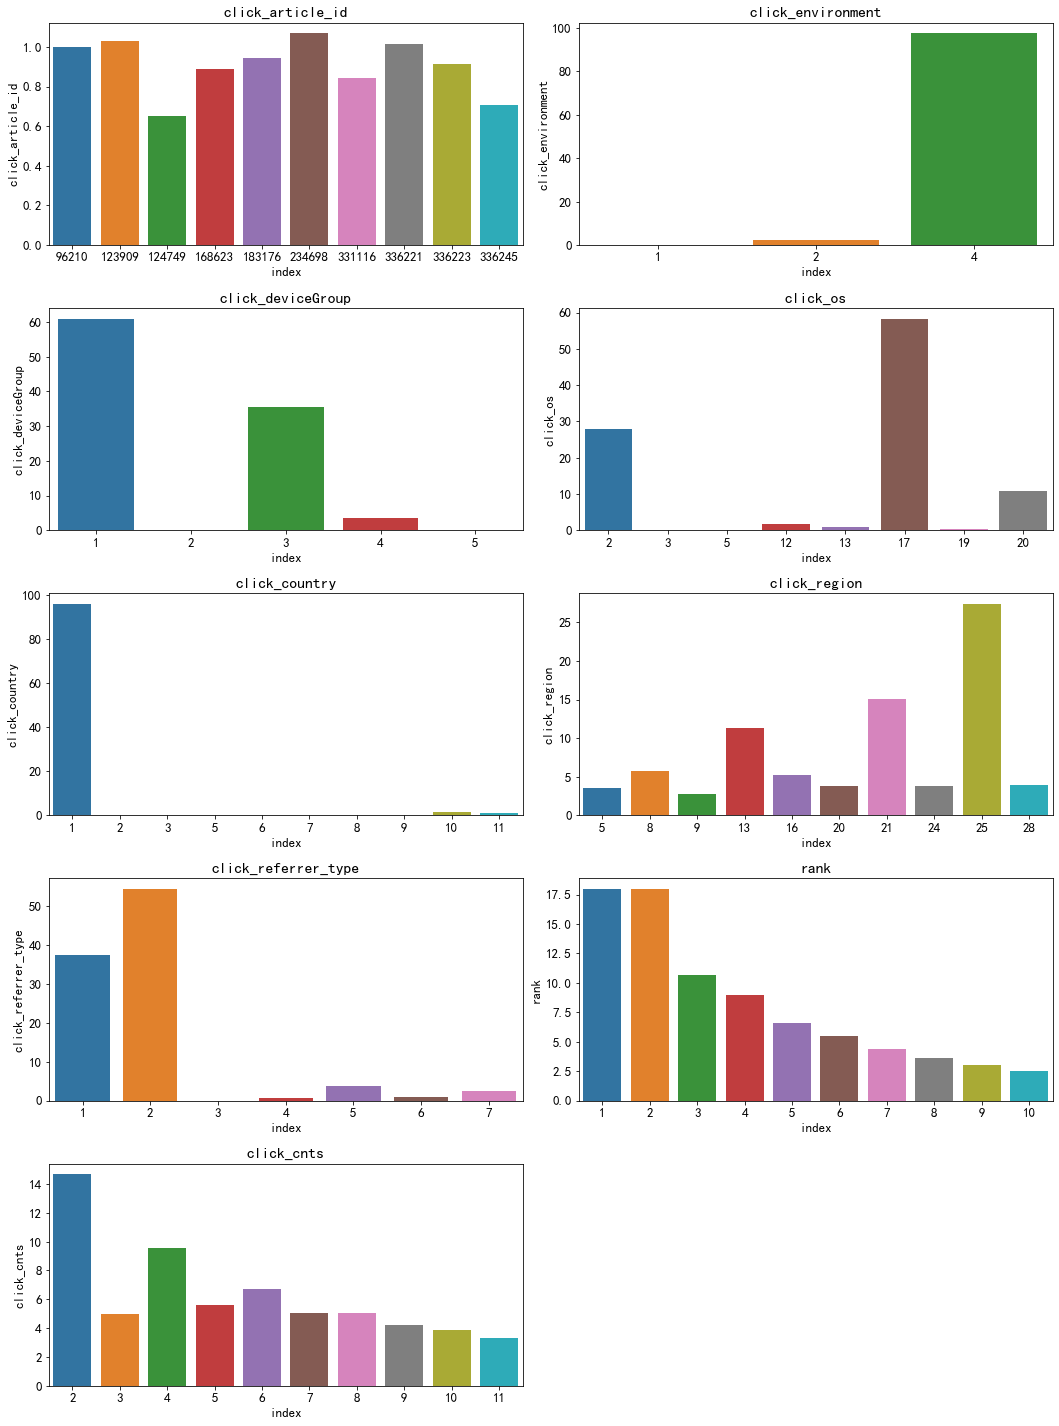

In [4]:
#查看各个特征的分布情况，纵坐标为百分比
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col]/trn_click.shape[0]*100)
    plt.title(col)
plt.tight_layout()
plt.show()

461


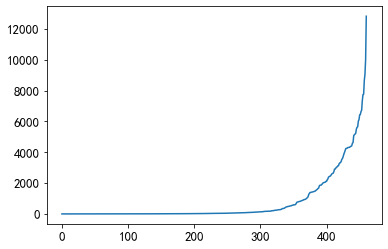

In [5]:
print(item_df['category_id'].nunique())     # 461个文章主题
plt.plot(sorted(item_df['category_id'].value_counts()))

In [7]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

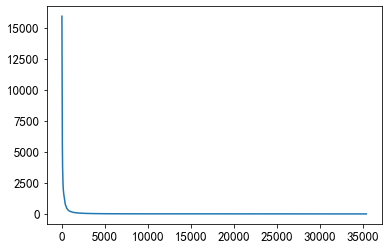

In [9]:
user_click_merge = trn_click.append(tst_click)
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)
plt.plot(item_click_count)

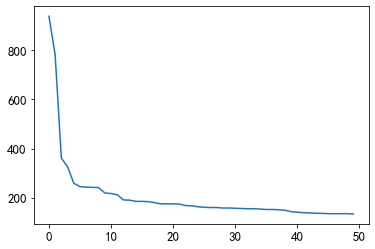

In [10]:
#画出点击次数在前50的用户
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count[:50])

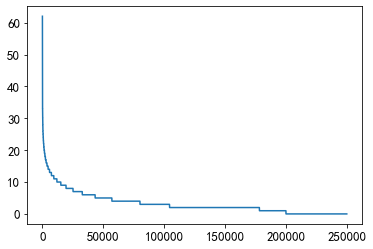

In [11]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

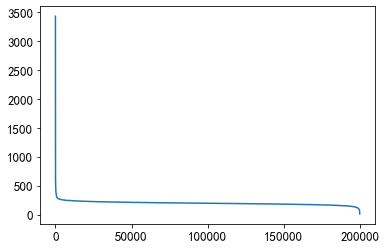

In [12]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

经过分析可以得出如下的结论：

### 可以通过数据查看确定热门文章和热门用户
### 不同文章的长度和文章类型被点击的次数不一样
### 文章本身分布差异也很大，不同类型的和不同字数的文章数目本身也不一样，所以可能导致2.的情况出现